In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = "drive/My Drive/DLSS/Src"
os.chdir(path)

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
import cv2
import os

In [4]:
class CelebA(torch.utils.data.Dataset):
  def __init__(self, input_imgs_path=""):
    input_imgs_name = os.listdir(input_imgs_path)
    self.input_image_paths = [os.path.join(input_imgs_path,name) for name in input_imgs_name]

  def __len__(self):
    length = len(self.input_image_paths)
    return length

  def __getitem__(self, idx):
    input_image_path = self.input_image_paths[idx]
    input_image = cv2.imread(input_image_path)
    input_image = cv2.normalize(input_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    input_image = cv2.resize(input_image, (128,128))
    b,g,r = cv2.split(input_image)  
    input_image = cv2.merge([r,g,b]) 
    return input_image


In [59]:
class DLSS(torch.nn.Module):
    def __init__(self):
        super(DLSS, self).__init__()
        
        self.Encoder = nn.Sequential(
            nn.MaxPool2d(2, stride=2)
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(3),
        )
    
    def encoder(self,image):

        code = self.Encoder(image)
        return code
    
    def decoder(self,code):

        dlss_image = self.Decoder(code)
        return dlss_image
    
    def forward(self,image):

        x = self.Encoder(image)
        dlss_image = self.Decoder(x)
        return dlss_image

In [61]:
celeba_train_data_path = "../Dataset/CelebA/train/"
celeba_train_dataset = CelebA(celeba_train_data_path)
torch_train_celeba = DataLoader(celeba_train_dataset,shuffle=True,batch_size=1,num_workers=1)

In [62]:
celeba_validation_data_path = "../Dataset/CelebA/validation/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)
torch_validation_celeba = DataLoader(celeba_validation_dataset,shuffle=True,batch_size=1,num_workers=1)

In [63]:
def reconstruction_loss(input,target):
    criterion = nn.MSELoss()
    recon_loss = criterion(input, target)
    return recon_loss

In [65]:
epochs = 100
celeba_dlss = DLSS()
celeba_dlss = celeba_dlss.cuda()
celeba_optimizer = optim.Adam(celeba_dlss.parameters(), lr=0.001)

for ep in range(epochs):
    for i,data in enumerate(torch_train_celeba):

        data = data.permute(0,3,1,2)
        data = data.float()
        data = data.cuda()

        celeba_optimizer.zero_grad()
        output = celeba_dlss(data)
        loss = reconstruction_loss(data, output)
        loss.backward()
        celeba_optimizer.step()
    #if ep % 2 == 0:
    print("Epoch : " + str(ep))
    print("loss : ")
    print(loss)
    
    celeba_dlss.eval()
    valid_loss = 0
    for i,data in enumerate(torch_validation_celeba):
        # WRITE YOUR CelebA VALIDATION LOOP HERE.
        data = data.permute(0,3,1,2)
        data = data.float()
        data = data.cuda()
        output = celeba_dlss(data)
        loss = reconstruction_loss(data, output) 
        valid_loss += loss.item()
    print("valid_loss : ")
    print(valid_loss)

Epoch : 0
loss : 
tensor(0.6287, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
50.777356430888176
Epoch : 1
loss : 
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.9569168849848211
Epoch : 2
loss : 
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.48328361811582
Epoch : 3
loss : 
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.5278055178932846
Epoch : 4
loss : 
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.4643155321246013
Epoch : 5
loss : 
tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.46208341349847615
Epoch : 6
loss : 
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.366268448298797
Epoch : 7
loss : 
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.5004432993009686
Epoch : 8
loss : 
tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>)
valid_loss : 
0.2923581868526526
Epoch : 9
lo

In [67]:
path_dlss = "../Model/model_dlss.pt"
torch.save(celeba_dlss, path_dlss) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


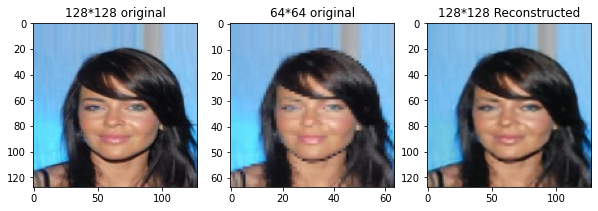

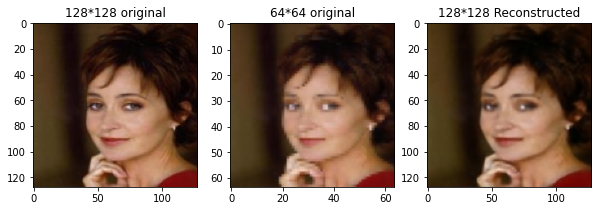

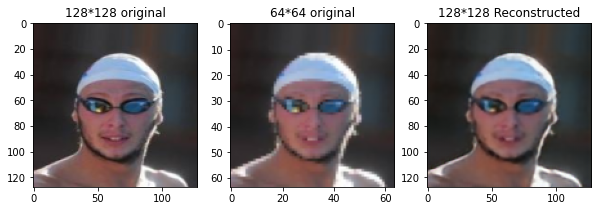

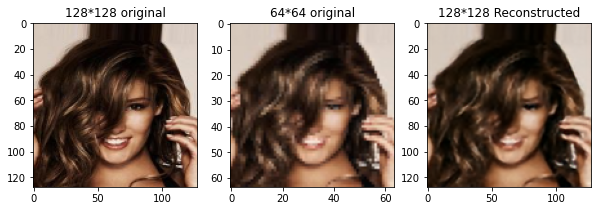

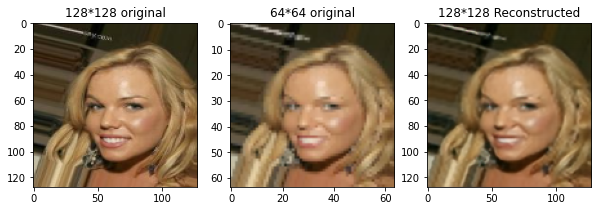

In [66]:
import random
import matplotlib.pyplot as plt

celeba_random_images = random.sample(list(celeba_validation_dataset),5)
torch_test_celeba = DataLoader(celeba_random_images,shuffle=True,batch_size=1,num_workers=1)

for i,data in enumerate(torch_test_celeba):
  input = data
  input = input.permute(0,3,1,2)
  input = input.float()
  input = input.cuda()
  input_64 = celeba_dlss.Encoder(input)
  output = celeba_dlss.Decoder(input_64)
  
  f,ax = plt.subplots(1,3,figsize=(10,10))
  ax[0].set_title("128*128 original")
  ax[1].set_title("64*64 original")
  ax[2].set_title("128*128 Reconstructed")

  input = input.view(3,128,128)
  input = input.permute(1,2,0).squeeze(2)
  input = input.detach().cpu().numpy()

  input_64 = input_64.view(3,64,64)
  input_64 = input_64.permute(1,2,0).squeeze(2)
  input_64 = input_64.detach().cpu().numpy()

  output = output.view(3,128,128)
  output = output.permute(1,2,0).squeeze(2)
  output = output.detach().cpu().numpy()

  ax[0].imshow(input)
  ax[1].imshow(input_64)
  ax[2].imshow(output)
